In [1]:
from geopandas.tools import sjoin
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import sys

#wor_dir="/home/fbf/"
#wor_dir='C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model/'
wor_dir='/home/mforooshani//Typhoon-Impact-based-forecasting-model-training-5:7/IBF-Typhoon-model/'
os.chdir(wor_dir)


### Source for pre disaster indicators: https://data.humdata.org/dataset/philippines-pre-disaster-indicators

In [2]:
#file_name = "data/pre_disaster_indicators/190108_pantawid-pamilya-beneficiary-households-and-household-members-by-sex-and-age-group.xlsx"
file_name = "Training-data-new/190108_pantawid-pamilya-beneficiary-households-and-household-members-by-sex-and-age-group.xlsx"

#main_file=pd.read_excel(file_name)
#print(main_file)

path = os.path.join(wor_dir, file_name)
#pd_check=pd.read_excel(path)
#display(pd_check)

#df = pd.read_excel(path, sheet_name="Data")
#display(df)
#for column in df:
    #print (df[column].apply(type))

pantawid_pamilya_beneficiary = pd.read_excel(path, sheet_name="Data", engine="openpyxl").filter(['PCODE_MUN_CTY','Total # of Active HHs','Total HH MEM_M','Total HH MEM_F'])
#pantawid_pamilya_beneficiary['Municipality_City Code']=pantawid_pamilya_beneficiary['PCODE_MUN_CTY']
display(pantawid_pamilya_beneficiary)

pantawid_pamilya_beneficiary.rename(columns={"PCODE_MUN_CTY": "Mun_Code"},inplace=True)
pantawid_pamilya_beneficiary['pantawid_total_pop']=pantawid_pamilya_beneficiary["Total HH MEM_M"]+pantawid_pamilya_beneficiary["Total HH MEM_F"]
pantawid_pamilya_beneficiary =  pantawid_pamilya_beneficiary.filter(['Mun_Code','Total # of Active HHs','pantawid_total_pop'])
display(pantawid_pamilya_beneficiary.head())
 

 


,PCODE_MUN_CTY,Total # of Active HHs,Total HH MEM_M,Total HH MEM_F
0,PH133902000,101,269,271
1,PH133908000,201,443,452
2,PH133909000,252,642,661
3,PH133910000,989,2939,2871
4,PH133911000,1038,2930,2929
...,...,...,...,...
1635,PH157004000,2407,5719,6158
1636,PH157005000,2512,6907,6914
1637,PH157006000,2261,5895,6171
1638,PH157007000,2789,7617,7860


,Mun_Code,Total # of Active HHs,pantawid_total_pop
0,PH133902000,101,540
1,PH133908000,201,895
2,PH133909000,252,1303
3,PH133910000,989,5810
4,PH133911000,1038,5859


### population per admin 

In [3]:
#file_name = "data/pre_disaster_indicators/180814_philippines-population-admin-1-to-3_2015_vertical.xlsx"
file_name = "Training-data-new/180814_philippines-population-admin-1-to-3_2015_vertical.xlsx"
path = os.path.join(wor_dir, file_name)

#df= pd.read_excel(path, sheet_name="Municipality")
#display(df)
#for column in df:
    #print (df[column].apply(type))

population_admin = pd.read_excel(path, sheet_name="Municipality", engine="openpyxl").filter(['Municipality_City Code','Female','Male']).groupby('Municipality_City Code').agg('sum')

population_admin['Total Pop']=population_admin.sum(axis="columns") 
population_admin['Mun_Code']=population_admin.index.tolist()

population_admin.reset_index(drop=True, inplace=True)

#population_admin.rename(columns={"Municipality_City Code": "Mun_Code"},inplace=True)
display(population_admin.head())

,Female,Male,Total Pop,Mun_Code
0,825,967,1792,PH012801000
1,16175,16040,32215,PH012802000
2,15564,16052,31616,PH012803000
3,7422,7250,14672,PH012804000
4,27695,27506,55201,PH012805000


### vulnerable Groups

In [4]:
#file_name = "data/pre_disaster_indicators/180814_vulnerable-groups_by-city_municipality.xlsx"
file_name = "Training-data-new/180814_vulnerable-groups_by-city_municipality.xlsx"
path = os.path.join(wor_dir, file_name)

#df= pd.read_excel(path, sheet_name="Data")
#display(df)
#for column in df:
    #print (df[column].apply(type))

vulnerable_groups = pd.read_excel(path, sheet_name="Data", engine="openpyxl")

vulnerable_groups['vulnerable_groups']=vulnerable_groups.sum(axis="columns")
vulnerable_groups=vulnerable_groups.filter(['Municipality_City Code','vulnerable_groups'])
vulnerable_groups.rename(columns={"Municipality_City Code": "Mun_Code"},inplace=True)
display(vulnerable_groups.head())

/tmp/ipykernel_498310/2076735071.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vulnerable_groups['vulnerable_groups']=vulnerable_groups.sum(axis="columns")


,Mun_Code,vulnerable_groups
0,PH012801000,44
1,PH012802000,173
2,PH012803000,461
3,PH012804000,164
4,PH012805000,334


### housing material

In [5]:
#file_name = "data/pre_disaster_indicators/180814_construction-materials-of-the-outer-walls-and-roof_by-city_municipality.xlsx"
file_name = "Training-data-new/180814_construction-materials-of-the-outer-walls-and-roof_by-city_municipality.xlsx"
path = os.path.join(wor_dir, file_name)

#df= pd.read_excel(path, sheet_name="by category")
#display(df)
#for column in df:
    #print (df[column].apply(type))

construction_materials = pd.read_excel(path, sheet_name="by category", engine="openpyxl")
construction_materials.rename(columns={"Municipality_City Code": "Mun_Code"},inplace=True)
construction_materials=construction_materials.filter(['Mun_Code', 'Housing Units','Strong Roof/Strong Wall', 'Strong Roof/Light Wall','Strong Roof/Salvage Wall', 'Light Roof/Strong Wall','Light Roof/Light Wall', 'Light Roof/Salvage Wall','Salvaged Roof/Strong Wall', 'Salvaged Roof/Light Wall', 'Salvaged Roof/Salvage Wall'])

df_cons_mat=construction_materials.iloc[:,2:].div(0.01*construction_materials["Housing Units"], axis=0)
df_cons_mat['Mun_Code']=construction_materials['Mun_Code']
df_cons_mat["Housing Units"]=construction_materials["Housing Units"]

display(df_cons_mat.head())


,Strong Roof/Strong Wall,Strong Roof/Light Wall,Strong Roof/Salvage Wall,Light Roof/Strong Wall,Light Roof/Light Wall,Light Roof/Salvage Wall,Salvaged Roof/Strong Wall,Salvaged Roof/Light Wall,Salvaged Roof/Salvage Wall,Mun_Code,Housing Units
0,17.226562,48.046875,0.000000,4.960938,29.570312,0.000000,0.000000,0.000000,0.000000,PH150708000,2560
1,13.792158,50.808884,0.027420,0.658075,34.357006,0.054840,0.000000,0.082259,0.000000,PH150709000,3647
2,33.706189,42.600502,0.162701,0.698258,21.991729,0.067792,0.040675,0.223714,0.155922,PH150702000,14751
3,18.565708,44.339279,0.254823,0.364033,36.075719,0.182017,0.000000,0.036403,0.036403,PH150710000,2747
4,8.849783,33.384341,0.127518,0.765111,56.490691,0.076511,0.000000,0.127518,0.153022,PH150712000,3921


In [6]:
#df_cm=construction_materials
#df_cm.rename(columns ={'Housing Units':'HUNITS', 'Strong Roof/Strong Wall':'SRSW','Strong Roof/Light Wall':'SRLW', 'Strong Roof/Salvage Wall':'SRSW','Light Roof/Strong Wall':'LRSW', 'Light Roof/Light Wall':'LRLW','Light Roof/Salvage Wall':'LRSW', 'Salvaged Roof/Strong Wall':'SRSW','Salvaged Roof/Light Wall':'SRLW', 'Salvaged Roof/Salvage Wall':'SRSW'},inplace=True)


In [7]:
len(construction_materials['Housing Units'])

1633

### Data on topography related variables 

In [8]:
#geo_variable = pd.read_csv("data/topography/geo_variable.csv")
geo_variable = pd.read_csv("Training-data-new/geo_variable.csv")
display(geo_variable)
#for column in geo_variable:
    #print (geo_variable[column].apply(type))

geo_variable=geo_variable.filter(['Mun_Code', 'mean_slope', 'mean_elevation_m','ruggedness_stdev', 'mean_ruggedness', 'slope_stdev', 'area_km2','poverty_perc', 'with_coast', 'coast_length', 'perimeter'])

display(geo_variable.head())

,Mun_name,Mun_Code,mean_slope,mean_elevation_m,ruggedness_stdev,mean_ruggedness,slope_stdev,area_km2,poverty_perc,with_coast,coast_length,perimeter
0,ADAMS,PH012801000,16.83,558.75,39.76,84.41,8.54,111,10.10,0,NaN,45998
1,BACARRA,PH012802000,2.13,23.80,12.14,12.05,2.49,55,2.07,1,4294.0,33314
2,BADOC,PH012803000,7.37,97.70,39.58,37.37,8.27,81,4.99,1,15821.0,64986
3,BANGUI,PH012804000,11.94,220.47,41.11,59.74,8.83,115,3.75,1,11813.0,52052
4,CITY OF BATAC,PH012805000,5.23,91.41,23.81,27.49,5.18,158,3.22,0,NaN,66662
...,...,...,...,...,...,...,...,...,...,...,...,...
1641,CITY OF TANJAY,PH184621000,6.48,296.53,30.77,32.81,6.51,228,2.78,1,17798.0,113689
1642,TAYASAN,PH184622000,12.77,513.35,41.59,63.47,8.69,177,6.51,1,10441.0,62045
1643,VALENCIA (LUZURRIAGA),PH184623000,16.65,823.81,48.54,84.76,9.62,163,2.06,0,NaN,60038
1644,VALLEHERMOSO,PH184624000,12.24,217.89,35.66,61.82,7.81,93,7.16,1,178.0,46125


,Mun_Code,mean_slope,mean_elevation_m,ruggedness_stdev,mean_ruggedness,slope_stdev,area_km2,poverty_perc,with_coast,coast_length,perimeter
0,PH012801000,16.83,558.75,39.76,84.41,8.54,111,10.10,0,NaN,45998
1,PH012802000,2.13,23.80,12.14,12.05,2.49,55,2.07,1,4294.0,33314
2,PH012803000,7.37,97.70,39.58,37.37,8.27,81,4.99,1,15821.0,64986
3,PH012804000,11.94,220.47,41.11,59.74,8.83,115,3.75,1,11813.0,52052
4,PH012805000,5.23,91.41,23.81,27.49,5.18,158,3.22,0,NaN,66662


### Data for Land slide /storm surge vulnerable areas 

In [9]:
#data_matrix_new_variables = pd.read_csv("data/landuse_stormsurge/data_matrix_new_variables.csv")
data_matrix_new_variables = pd.read_csv("Training-data-new/data_matrix_new_variables.csv")

#for column in data_matrix_new_variables:
    #print (data_matrix_new_variables[column].apply(type))

data_matrix_new_variables=data_matrix_new_variables.filter(['Mun_Code', 'landslide_per', 'stormsurge_per', 'Bu_p_inSSA','Bu_p_LS', 'Red_per_LSbldg', 'Or_per_LSblg', 'Yel_per_LSSAb','RED_per_SSAbldg', 'OR_per_SSAbldg', 'Yellow_per_LSbl'])
display(data_matrix_new_variables.head())

,Mun_Code,landslide_per,stormsurge_per,Bu_p_inSSA,Bu_p_LS,Red_per_LSbldg,Or_per_LSblg,Yel_per_LSSAb,RED_per_SSAbldg,OR_per_SSAbldg,Yellow_per_LSbl
0,PH012801000,4.08,0.00,0.00,4.08,4.08,0.0,0.00,0.00,0.00,0.00
1,PH012802000,1.41,1.54,1.54,1.41,0.00,0.0,1.41,1.48,0.03,0.03
2,PH012803000,2.45,1.68,1.68,2.45,0.04,0.0,2.40,1.64,0.00,0.04
3,PH012804000,2.88,1.51,1.51,2.88,0.41,0.0,2.47,1.44,0.00,0.07
4,PH012805000,0.03,0.03,0.03,0.03,0.03,0.0,0.00,0.00,0.00,0.03


In [10]:
#this part added by me only to save a csv file for typhoon charactristic

impact = pd.read_csv("Training-data-new/data/Impact/IMpact_data_philipines_SEP_2021.csv")

impact['typhoon']=impact["typhoon"].astype(str)  + impact["Year"].astype(str)
impact['typhoon']= impact['typhoon'].map(lambda x: x.lower())
impact.rename(columns={"pcode": "Mun_Code"},inplace=True)

impact_new = impact.filter(['Mun_Code','typhoon','Totally'])
display(impact_new)

path=os.path.join(wor_dir, "/home/mforooshani/Test_Folder/data/impact_new.csv")
impact_new.to_csv(path, index=False)


,Mun_Code,typhoon,Totally
0,PH041005000,durian2006,84.0
1,PH041006000,durian2006,1.0
2,PH041010000,durian2006,4.0
3,PH041014000,durian2006,0.0
4,PH041020000,durian2006,16.0
...,...,...,...
4984,PH020902000,meranti2016,172.0
4985,PH020903000,meranti2016,10.0
4986,PH020904000,meranti2016,11.0
4987,PH020905000,meranti2016,19.0


### Impact Data(Damage and Loss data)

In [11]:
#df_total["perc_loss"] = df_total.apply(lambda x: division(x["area_affected"], x["rice_area"]), axis=1).values
#impact = pd.read_csv("data/Impact/IMpact_data_philipines_SEP_2021.csv")
impact = pd.read_csv("Training-data-new/data/Impact/IMpact_data_philipines_SEP_2021.csv")
display(impact)

impact['typhoon']=impact["typhoon"].astype(str)  + impact["Year"].astype(str)
impact['typhoon']= impact['typhoon'].map(lambda x: x.lower())
impact.rename(columns={"pcode": "Mun_Code"},inplace=True)
typhoons_with_impact_data=list(np.unique(impact.typhoon))
display(impact.head())

impact=impact[['Mun_Code','typhoon','Totally','Partially','total']]
df_impact=impact[['typhoon','Totally']].groupby('typhoon').sum().sort_values(by='Totally',ascending=False)#.head(n=10)

df_impact.reset_index(inplace=True)
df_impact['typhoon_name']=df_impact['typhoon'].apply(lambda x:(x[:-4].upper()+'-'+x[-4:]))
display(df_impact)


,Id,pcode,typhoon,Year,Totally,Partially,total
0,1,PH041005000,Durian,2006,84.0,588.0,672.0
1,2,PH041006000,Durian,2006,1.0,7.0,8.0
2,3,PH041010000,Durian,2006,4.0,48.0,52.0
3,4,PH041014000,Durian,2006,0.0,78.0,78.0
4,5,PH041020000,Durian,2006,16.0,169.0,185.0
...,...,...,...,...,...,...,...
4984,4985,PH020902000,MERANTI,2016,172.0,447.0,619.0
4985,4986,PH020903000,MERANTI,2016,10.0,111.0,121.0
4986,4987,PH020904000,MERANTI,2016,11.0,177.0,188.0
4987,4988,PH020905000,MERANTI,2016,19.0,165.0,184.0


,Id,Mun_Code,typhoon,Year,Totally,Partially,total
0,1,PH041005000,durian2006,2006,84.0,588.0,672.0
1,2,PH041006000,durian2006,2006,1.0,7.0,8.0
2,3,PH041010000,durian2006,2006,4.0,48.0,52.0
3,4,PH041014000,durian2006,2006,0.0,78.0,78.0
4,5,PH041020000,durian2006,2006,16.0,169.0,185.0


,typhoon,Totally,typhoon_name
0,haiyan2013,550928.0,HAIYAN-2013
1,durian2006,214400.0,DURIAN-2006
2,rammasun2014,114309.0,RAMMASUN-2014
3,melor2015,110036.0,MELOR-2015
4,bopha2012,89090.0,BOPHA-2012
5,fengshen2008,87116.0,FENGSHEN-2008
6,nock-ten2016,85233.0,NOCK-TEN-2016
7,kammuri2019,82876.0,KAMMURI-2019
8,goni2020,69576.0,GONI-2020
9,phanfone2019,66131.0,PHANFONE-2019


In [12]:
display(impact.head())

,Mun_Code,typhoon,Totally,Partially,total
0,PH041005000,durian2006,84.0,588.0,672.0
1,PH041006000,durian2006,1.0,7.0,8.0
2,PH041010000,durian2006,4.0,48.0,52.0
3,PH041014000,durian2006,0.0,78.0,78.0
4,PH041020000,durian2006,16.0,169.0,185.0


### number of Households per Manucipality 

In [13]:
#file_name = "data/pre_disaster_indicators/180814_number-of-household_by-city_municipality.xlsx"
file_name = "Training-data-new/180814_number-of-household_by-city_municipality.xlsx"

path = os.path.join(wor_dir, file_name)
df= household_by_city_municipality = pd.read_excel(path, sheet_name="Data")
display(df)

#for column in df:
    #print (df[column].apply(type))

household_by_city_municipality = pd.read_excel(path, sheet_name="Data", engine="openpyxl").filter(['Municipality_City','Municipality_City Code','Number of Household'])
household_by_city_municipality.rename(columns={"Municipality_City Code": "Mun_Code"},inplace=True)
household_by_city_municipality=household_by_city_municipality.filter(['Mun_Code','Number of Household'])
display(household_by_city_municipality.head())


,Region,Region Code,Province,Province Code,Municipality_City,Municipality_City Code,Number of Household
0,Region I (Ilocos Region),PH010000000,Ilocos Norte,PH012800000,Adams,PH012801000,411
1,Region I (Ilocos Region),PH010000000,Ilocos Norte,PH012800000,Bacarra,PH012802000,8269
2,Region I (Ilocos Region),PH010000000,Ilocos Norte,PH012800000,Badoc,PH012803000,7375
3,Region I (Ilocos Region),PH010000000,Ilocos Norte,PH012800000,Bangui,PH012804000,3568
4,Region I (Ilocos Region),PH010000000,Ilocos Norte,PH012800000,City of Batac,PH012805000,12797
...,...,...,...,...,...,...,...
1642,Region VII (Central Visayas),PH070000000,Negros Oriental,PH074600000,City of Tanjay,PH074621000,19043
1643,Region VII (Central Visayas),PH070000000,Negros Oriental,PH074600000,Tayasan,PH074622000,8623
1644,Region VII (Central Visayas),PH070000000,Negros Oriental,PH074600000,Valencia (Luzurriaga),PH074623000,7990
1645,Region VII (Central Visayas),PH070000000,Negros Oriental,PH074600000,Vallehermoso,PH074624000,8571


,Mun_Code,Number of Household
0,PH012801000,411
1,PH012802000,8269
2,PH012803000,7375
3,PH012804000,3568
4,PH012805000,12797


### historical Typhoons Methadata (name, start date, end date, land fall)

In [14]:
#typhoon_metadata_filename = os.path.join(wor_dir, "data/rainfall_data/input/metadata_typhoons.csv")
typhoon_metadata_filename = os.path.join(wor_dir, "Training-data-new/data/rainfall_data/input/metadata_typhoons.csv")
typhoon_metadata = pd.read_csv(typhoon_metadata_filename, delimiter=",")
display(typhoon_metadata)

#for column in typhoon_metadata:
    #print (typhoon_metadata[column].apply(type))

typhoons = list(np.unique(impact.typhoon.values))# typhoon_metadata.typhoon.tolist() ## historical typhoon events 
municipalities=population_admin.Mun_Code.tolist() 

display(typhoons)          #get the list of typhoons from imact file in previous steps
display(municipalities)   #get the list of municipalities from population_admin in previous steps

N_typh = len(typhoons)
N_mun = len(municipalities)

municipality_codes_full = np.repeat(municipalities, N_typh)
display(municipality_codes_full)
typhoons_full = typhoons * N_mun
display(typhoons_full)

,typhoon,startdate,enddate,landfalldate,landfall_time,imerg_type
0,durian2006,24/11/2006,09/12/2006,30/11/2006,06:00:00,final
1,fengshen2008,17/06/2008,25/06/2008,20/06/2008,06:00:00,final
2,aere2011,05/05/2011,15/05/2011,07/05/2011,21:00:00,final
3,atsani2020,29/10/2020,07/11/2020,06/11/2020,00:00:00,final
4,bopha2012,25/11/2012,09/12/2012,03/12/2012,21:00:00,final
5,danas2019,14/07/2019,23/07/2019,17/07/2019,00:00:00,final
6,fung-wong2014,17/09/2014,25/09/2014,19/09/2014,03:00:00,final
7,goni2015,13/08/2015,30/08/2015,22/08/2015,00:00:00,final
8,goni2020,28/10/2020,06/11/2020,31/10/2020,21:00:00,final
9,hagupit2014,30/11/2014,12/12/2014,06/12/2014,18:00:00,final


['bopha2012',
 'conson2010',
 'durian2006',
 'fengshen2008',
 'fung-wong2014',
 'goni2015',
 'goni2020',
 'hagupit2014',
 'haima2016',
 'haiyan2013',
 'jangmi2014',
 'kalmaegi2014',
 'kammuri2019',
 'ketsana2009',
 'koppu2015',
 'krosa2013',
 'linfa2015',
 'lingling2014',
 'mangkhut2018',
 'mekkhala2015',
 'melor2015',
 'meranti2016',
 'molave2020',
 'mujigae2015',
 'nakri2019',
 'nari2013',
 'nesat2011',
 'nock-ten2016',
 'noul2015',
 'phanfone2019',
 'rammasun2014',
 'sarika2016',
 'saudel2020',
 'tokage2016',
 'trami2013',
 'usagi2013',
 'utor2013',
 'vamco2020',
 'vongfong2020',
 'yutu2018']

['PH012801000',
 'PH012802000',
 'PH012803000',
 'PH012804000',
 'PH012805000',
 'PH012806000',
 'PH012807000',
 'PH012808000',
 'PH012809000',
 'PH012810000',
 'PH012811000',
 'PH012812000',
 'PH012813000',
 'PH012814000',
 'PH012815000',
 'PH012816000',
 'PH012817000',
 'PH012818000',
 'PH012819000',
 'PH012820000',
 'PH012821000',
 'PH012822000',
 'PH012823000',
 'PH012901000',
 'PH012902000',
 'PH012903000',
 'PH012904000',
 'PH012905000',
 'PH012906000',
 'PH012907000',
 'PH012908000',
 'PH012909000',
 'PH012910000',
 'PH012911000',
 'PH012912000',
 'PH012913000',
 'PH012914000',
 'PH012915000',
 'PH012916000',
 'PH012917000',
 'PH012918000',
 'PH012919000',
 'PH012920000',
 'PH012921000',
 'PH012922000',
 'PH012923000',
 'PH012924000',
 'PH012925000',
 'PH012926000',
 'PH012927000',
 'PH012928000',
 'PH012929000',
 'PH012930000',
 'PH012931000',
 'PH012932000',
 'PH012933000',
 'PH012934000',
 'PH013301000',
 'PH013302000',
 'PH013303000',
 'PH013304000',
 'PH013305000',
 'PH0133

array(['PH012801000', 'PH012801000', 'PH012801000', ..., 'PH175917000',
       'PH175917000', 'PH175917000'], dtype='<U11')

['bopha2012',
 'conson2010',
 'durian2006',
 'fengshen2008',
 'fung-wong2014',
 'goni2015',
 'goni2020',
 'hagupit2014',
 'haima2016',
 'haiyan2013',
 'jangmi2014',
 'kalmaegi2014',
 'kammuri2019',
 'ketsana2009',
 'koppu2015',
 'krosa2013',
 'linfa2015',
 'lingling2014',
 'mangkhut2018',
 'mekkhala2015',
 'melor2015',
 'meranti2016',
 'molave2020',
 'mujigae2015',
 'nakri2019',
 'nari2013',
 'nesat2011',
 'nock-ten2016',
 'noul2015',
 'phanfone2019',
 'rammasun2014',
 'sarika2016',
 'saudel2020',
 'tokage2016',
 'trami2013',
 'usagi2013',
 'utor2013',
 'vamco2020',
 'vongfong2020',
 'yutu2018',
 'bopha2012',
 'conson2010',
 'durian2006',
 'fengshen2008',
 'fung-wong2014',
 'goni2015',
 'goni2020',
 'hagupit2014',
 'haima2016',
 'haiyan2013',
 'jangmi2014',
 'kalmaegi2014',
 'kammuri2019',
 'ketsana2009',
 'koppu2015',
 'krosa2013',
 'linfa2015',
 'lingling2014',
 'mangkhut2018',
 'mekkhala2015',
 'melor2015',
 'meranti2016',
 'molave2020',
 'mujigae2015',
 'nakri2019',
 'nari2013',
 '

### create data frame for all pre disaster indicators 

In [15]:
data_temp1 = {"Mun_Code": municipality_codes_full}#, "typhoon": typhoons_full}
#display(data_temp1)
df_temp_total = pd.DataFrame(data_temp1)

##data_matrix_new_variables
df_temp_total=df_temp_total.join(household_by_city_municipality.set_index('Mun_Code'), on='Mun_Code')

##data_matrix_new_variables
df_temp_total=df_temp_total.join(data_matrix_new_variables.set_index('Mun_Code'), on='Mun_Code')

#geo_variable
df_temp_total=df_temp_total.join(geo_variable.set_index('Mun_Code'), on='Mun_Code')
#construction_materials
df_temp_total=df_temp_total.join(df_cons_mat.set_index('Mun_Code'), on='Mun_Code')
#vulnerable_groups
df_temp_total=df_temp_total.join(vulnerable_groups.set_index('Mun_Code'), on='Mun_Code')
#population_admin
df_temp_total=df_temp_total.join(population_admin.set_index('Mun_Code'), on='Mun_Code')
#pantawid_pamilya_beneficiary
df_temp_total=df_temp_total.join(pantawid_pamilya_beneficiary.set_index('Mun_Code'), on='Mun_Code')
#display(df_temp_total)

def housing(df):
    x=float(df[0])
    y=df[1]
    if np.isnan(y) and x>0:
        value=x
    elif np.isnan(y) and x<1:
        value=1
    else:
        value=y
    return value
df_temp_total["Housing Units"] = df_temp_total[['Number of Household','Housing Units']].apply(housing, axis="columns")
 
    
df_predisasters=df_temp_total#.set_index(['Mun_Code', 'typhoon'])
#display(df_predisasters)

 

colnames=['landslide_per',
       'stormsurge_per', 'Bu_p_inSSA', 'Bu_p_LS', 'Red_per_LSbldg',
       'Or_per_LSblg', 'Yel_per_LSSAb', 'RED_per_SSAbldg', 'OR_per_SSAbldg',
       'Yellow_per_LSbl', 'mean_slope', 'mean_elevation_m', 'ruggedness_stdev',
       'mean_ruggedness', 'slope_stdev', 'area_km2', 'poverty_perc',
       'with_coast', 'coast_length', 'perimeter',
       'Strong Roof/Strong Wall', 'Strong Roof/Light Wall',
       'Strong Roof/Salvage Wall', 'Light Roof/Strong Wall',
       'Light Roof/Light Wall', 'Light Roof/Salvage Wall',
       'Salvaged Roof/Strong Wall', 'Salvaged Roof/Light Wall',
       'Salvaged Roof/Salvage Wall', 'vulnerable_groups', 'Female', 'Male',
       'Total Pop', 'Total # of Active HHs', 'Total HH MEM_M',
       'Total HH MEM_F']

for column in df_predisasters:
    if column in colnames:
        df_predisasters[column].fillna((df_predisasters[column].min(skipna=True)), inplace=True)
        
        
display(df_predisasters.head())

,Mun_Code,Number of Household,landslide_per,stormsurge_per,Bu_p_inSSA,Bu_p_LS,Red_per_LSbldg,Or_per_LSblg,Yel_per_LSSAb,RED_per_SSAbldg,...,Salvaged Roof/Strong Wall,Salvaged Roof/Light Wall,Salvaged Roof/Salvage Wall,Housing Units,vulnerable_groups,Female,Male,Total Pop,Total # of Active HHs,pantawid_total_pop
0,PH012801000,411,4.08,0.0,0.0,4.08,4.08,0.0,0.0,0.0,...,0.0,0.0,0.0,411.0,44,825,967,1792,169.0,840.0
1,PH012801000,411,4.08,0.0,0.0,4.08,4.08,0.0,0.0,0.0,...,0.0,0.0,0.0,411.0,44,825,967,1792,169.0,840.0
2,PH012801000,411,4.08,0.0,0.0,4.08,4.08,0.0,0.0,0.0,...,0.0,0.0,0.0,411.0,44,825,967,1792,169.0,840.0
3,PH012801000,411,4.08,0.0,0.0,4.08,4.08,0.0,0.0,0.0,...,0.0,0.0,0.0,411.0,44,825,967,1792,169.0,840.0
4,PH012801000,411,4.08,0.0,0.0,4.08,4.08,0.0,0.0,0.0,...,0.0,0.0,0.0,411.0,44,825,967,1792,169.0,840.0


In [16]:
df_predisasters.columns

Index(['Mun_Code', 'Number of Household', 'landslide_per', 'stormsurge_per',
       'Bu_p_inSSA', 'Bu_p_LS', 'Red_per_LSbldg', 'Or_per_LSblg',
       'Yel_per_LSSAb', 'RED_per_SSAbldg', 'OR_per_SSAbldg', 'Yellow_per_LSbl',
       'mean_slope', 'mean_elevation_m', 'ruggedness_stdev', 'mean_ruggedness',
       'slope_stdev', 'area_km2', 'poverty_perc', 'with_coast', 'coast_length',
       'perimeter', 'Strong Roof/Strong Wall', 'Strong Roof/Light Wall',
       'Strong Roof/Salvage Wall', 'Light Roof/Strong Wall',
       'Light Roof/Light Wall', 'Light Roof/Salvage Wall',
       'Salvaged Roof/Strong Wall', 'Salvaged Roof/Light Wall',
       'Salvaged Roof/Salvage Wall', 'Housing Units', 'vulnerable_groups',
       'Female', 'Male', 'Total Pop', 'Total # of Active HHs',
       'pantawid_total_pop'],
      dtype='object')

### Add Typhoon wind Data

In [17]:
#Adding the wind data

data_temp1 = {"Mun_Code": municipality_codes_full, "typhoon": typhoons_full}
df_total = pd.DataFrame(data_temp1)
#display(df_total)

df_total["vmax"] = ""
df_total["dis_track_min"] = ""

df_wind_final= pd.DataFrame(columns=["typhoon", "Mun_Code", "v_max","dis_track_min"])

for typhoon in typhoons:

    # Path to the rainfall excel sheet per typhoon
    wind_path = os.path.join(
        wor_dir,
        "Training-data-new/data/wind_data/output",
        typhoon +
        "_windgrid_output.csv",
    )
    df_temp = pd.read_csv(wind_path)
    display(df_temp)
    #for column in df_temp:
        #print (df_temp[column].apply(type))
    
    df_wind_single = pd.DataFrame({"Mun_Code": df_temp["adm3_pcode"],"v_max": df_temp["v_max"],
                                   "dis_track_min": df_temp["dis_track_min"] })
    df_wind_single['typhoon']=typhoon
    df_wind_final = df_wind_final.append(df_wind_single) 
    display(df_wind_final)
#for column in df_wind_final:
    #print (df_wind_final[column].apply(type))

,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2012331N03157,140,17.647616,154.916060
1,1,PH012802000,2012331N03157,102,20.480927,119.912285
2,2,PH012803000,2012331N03157,105,22.119431,112.853919
3,3,PH012804000,2012331N03157,244,18.892731,135.538786
4,4,PH012805000,2012331N03157,313,21.483395,115.798833
...,...,...,...,...,...,...
1068,1068,PH184621000,2012331N03157,218,56.748735,47.355115
1069,1069,PH184622000,2012331N03157,174,35.433109,96.094767
1070,1070,PH184623000,2012331N03157,253,64.679523,29.906251
1071,1071,PH184624000,2012331N03157,125,24.173678,147.010706


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
1068,bopha2012,PH184621000,56.748735,47.355115
1069,bopha2012,PH184622000,35.433109,96.094767
1070,bopha2012,PH184623000,64.679523,29.906251
1071,bopha2012,PH184624000,24.173678,147.010706


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012901000,2010191N12138,179,9.523517,255.990258
1,1,PH012902000,2010191N12138,21,8.709520,284.661704
2,2,PH012904000,2010191N12138,13,8.278566,296.898776
3,3,PH012906000,2010191N12138,108,9.019852,276.916374
4,4,PH012908000,2010191N12138,245,8.816796,269.378520
...,...,...,...,...,...,...
714,714,PH175913000,2010191N12138,280,11.130541,224.783704
715,715,PH175914000,2010191N12138,26,7.943906,258.792834
716,716,PH175915000,2010191N12138,58,8.637193,249.207669
717,717,PH175916000,2010191N12138,64,9.110617,231.719670


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
714,conson2010,PH175913000,11.130541,224.783704
715,conson2010,PH175914000,7.943906,258.792834
716,conson2010,PH175915000,8.637193,249.207669
717,conson2010,PH175916000,9.110617,231.71967


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH015501000,2006329N06150,161,10.945624,274.953818
1,1,PH015502000,2006329N06150,195,12.108701,252.828578
2,2,PH015503000,2006329N06150,124,10.543982,283.812673
3,3,PH015504000,2006329N06150,37,11.875680,258.590255
4,4,PH015506000,2006329N06150,46,10.711115,280.619001
...,...,...,...,...,...,...
741,741,PH184509000,2006329N06150,32,7.152373,296.442290
742,742,PH184518000,2006329N06150,21,7.272645,287.083980
743,743,PH184523000,2006329N06150,132,8.522683,285.815097
744,744,PH184526000,2006329N06150,14,6.789812,298.101585


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
741,durian2006,PH184509000,7.152373,296.44229
742,durian2006,PH184518000,7.272645,287.08398
743,durian2006,PH184523000,8.522683,285.815097
744,durian2006,PH184526000,6.789812,298.101585


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2008169N08135,38,10.203799,282.507240
1,1,PH012802000,2008169N08135,51,11.745000,252.460730
2,2,PH012803000,2008169N08135,72,14.244212,212.758139
3,3,PH012804000,2008169N08135,73,10.340640,279.741297
4,4,PH012805000,2008169N08135,197,13.555103,222.889719
...,...,...,...,...,...,...
1235,1235,PH184621000,2008169N08135,220,19.994287,234.347804
1236,1236,PH184622000,2008169N08135,250,24.282120,186.199253
1237,1237,PH184623000,2008169N08135,203,18.452498,255.394277
1238,1238,PH184624000,2008169N08135,244,30.356644,137.661226


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
1235,fengshen2008,PH184621000,19.994287,234.347804
1236,fengshen2008,PH184622000,24.28212,186.199253
1237,fengshen2008,PH184623000,18.452498,255.394277
1238,fengshen2008,PH184624000,30.356644,137.661226


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2014260N13135,257,16.653977,14.619409
1,1,PH012802000,2014260N13135,165,16.849423,36.585763
2,2,PH012803000,2014260N13135,152,14.780414,75.542022
3,3,PH012804000,2014260N13135,435,18.055367,8.754068
4,4,PH012805000,2014260N13135,469,15.557956,58.770177
...,...,...,...,...,...,...
329,329,PH148103000,2014260N13135,693,13.729094,39.187358
330,330,PH148104000,2014260N13135,2448,14.137617,46.852035
331,331,PH148105000,2014260N13135,1050,14.940090,24.073728
332,332,PH148106000,2014260N13135,701,13.958006,39.878757


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
329,fung-wong2014,PH148103000,13.729094,39.187358
330,fung-wong2014,PH148104000,14.137617,46.852035
331,fung-wong2014,PH148105000,14.94009,24.073728
332,fung-wong2014,PH148106000,13.958006,39.878757


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2015226N12151,232,14.893081,184.004946
1,1,PH012802000,2015226N12151,128,12.545767,223.982003
2,2,PH012803000,2015226N12151,97,11.358541,250.647094
3,3,PH012804000,2015226N12151,371,14.070744,195.936616
4,4,PH012805000,2015226N12151,345,12.005038,236.224076
...,...,...,...,...,...,...
165,165,PH148103000,2015226N12151,753,17.348194,159.009518
166,166,PH148104000,2015226N12151,2347,15.532252,182.084589
167,167,PH148105000,2015226N12151,1093,17.426393,154.588870
168,168,PH148106000,2015226N12151,728,16.912424,162.666031


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
165,goni2015,PH148103000,17.348194,159.009518
166,goni2015,PH148104000,15.532252,182.084589
167,goni2015,PH148105000,17.426393,154.58887
168,goni2015,PH148106000,16.912424,162.666031


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012901000,2020302N17140,88,10.615602,264.010053
1,1,PH012902000,2020302N17140,3,9.178697,299.339597
2,2,PH012906000,2020302N17140,23,9.460242,292.338017
3,3,PH012908000,2020302N17140,102,10.062009,274.532164
4,4,PH012909000,2020302N17140,6,9.303452,295.697429
...,...,...,...,...,...,...
816,816,PH184509000,2020302N17140,21,1.571640,296.369915
817,817,PH184518000,2020302N17140,13,1.714045,285.144363
818,818,PH184523000,2020302N17140,81,1.720178,285.134828
819,819,PH184526000,2020302N17140,12,1.561911,296.542789


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
816,goni2020,PH184509000,1.57164,296.369915
817,goni2020,PH184518000,1.714045,285.144363
818,goni2020,PH184523000,1.720178,285.134828
819,goni2020,PH184526000,1.561911,296.542789


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH013301000,2014334N02156,19,9.876291,283.458147
1,1,PH013302000,2014334N02156,26,9.594036,288.912722
2,2,PH013307000,2014334N02156,2,8.530549,299.832380
3,3,PH013309000,2014334N02156,11,9.277063,294.370865
4,4,PH013311000,2014334N02156,5,8.844403,298.800270
...,...,...,...,...,...,...
974,974,PH184613000,2014334N02156,241,12.340636,253.815352
975,975,PH184614000,2014334N02156,10,10.065292,298.781112
976,976,PH184615000,2014334N02156,18,10.102737,298.447383
977,977,PH184622000,2014334N02156,153,11.286449,271.379978


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
974,hagupit2014,PH184613000,12.340636,253.815352
975,hagupit2014,PH184614000,10.065292,298.781112
976,hagupit2014,PH184615000,10.102737,298.447383
977,hagupit2014,PH184622000,11.286449,271.379978


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2016288N07145,129,57.247132,30.764554
1,1,PH012802000,2016288N07145,87,52.392092,4.634785
2,2,PH012803000,2016288N07145,85,45.961194,33.882562
3,3,PH012804000,2016288N07145,215,56.073927,29.263573
4,4,PH012805000,2016288N07145,258,49.190427,16.895936
...,...,...,...,...,...,...
362,362,PH148103000,2016288N07145,383,61.430585,12.131609
363,363,PH148104000,2016288N07145,1367,58.076475,2.179573
364,364,PH148105000,2016288N07145,554,61.608080,23.320517
365,365,PH148106000,2016288N07145,385,60.629213,4.411101


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
362,haima2016,PH148103000,61.430585,12.131609
363,haima2016,PH148104000,58.076475,2.179573
364,haima2016,PH148105000,61.60808,23.320517
365,haima2016,PH148106000,60.629213,4.411101


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH030802000,2013306N07162,11,10.293053,293.289956
1,1,PH030806000,2013306N07162,6,10.226223,297.468462
2,2,PH030807000,2013306N07162,37,10.816893,285.320236
3,3,PH041001000,2013306N07162,34,13.785033,242.700608
4,4,PH041002000,2013306N07162,18,13.967060,239.625791
...,...,...,...,...,...,...
819,819,PH184621000,2013306N07162,137,14.639573,192.524743
820,820,PH184622000,2013306N07162,132,18.298164,144.722130
821,821,PH184623000,2013306N07162,145,13.718219,213.460621
822,822,PH184624000,2013306N07162,115,27.538693,96.061916


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
819,haiyan2013,PH184621000,14.639573,192.524743
820,haiyan2013,PH184622000,18.298164,144.72213
821,haiyan2013,PH184623000,13.718219,213.460621
822,haiyan2013,PH184624000,27.538693,96.061916


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH054101000,2014362N07130,310,9.974878,273.227283
1,1,PH054102000,2014362N07130,159,10.242716,271.420306
2,2,PH054103000,2014362N07130,432,11.252477,231.576752
3,3,PH054104000,2014362N07130,75,10.759700,274.705271
4,4,PH054105000,2014362N07130,348,12.987911,224.222177
...,...,...,...,...,...,...
880,880,PH184621000,2014362N07130,625,16.583011,23.781616
881,881,PH184622000,2014362N07130,500,18.120764,14.786140
882,882,PH184623000,2014362N07130,747,16.161286,49.814393
883,883,PH184624000,2014362N07130,385,20.079747,53.828259


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
880,jangmi2014,PH184621000,16.583011,23.781616
881,jangmi2014,PH184622000,18.120764,14.78614
882,jangmi2014,PH184623000,16.161286,49.814393
883,jangmi2014,PH184624000,20.079747,53.828259


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2014254N10142,105,44.301617,50.918642
1,1,PH012802000,2014254N10142,72,47.100244,31.503855
2,2,PH012803000,2014254N10142,74,37.226469,8.135830
3,3,PH012804000,2014254N10142,175,42.786705,55.255661
4,4,PH012805000,2014254N10142,220,41.766106,3.818370
...,...,...,...,...,...,...
373,373,PH148103000,2014254N10142,318,48.967608,19.320527
374,374,PH148104000,2014254N10142,1156,47.223060,0.809178
375,375,PH148105000,2014254N10142,446,48.666592,34.294033
376,376,PH148106000,2014254N10142,319,48.969142,13.741496


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
373,kalmaegi2014,PH148103000,48.967608,19.320527
374,kalmaegi2014,PH148104000,47.22306,0.809178
375,kalmaegi2014,PH148105000,48.666592,34.294033
376,kalmaegi2014,PH148106000,48.969142,13.741496


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH015501000,2019329N09160,136,9.432230,256.032818
1,1,PH015502000,2019329N09160,135,10.663803,249.439044
2,2,PH015503000,2019329N09160,119,9.127732,269.731982
3,3,PH015504000,2019329N09160,23,10.317610,273.454254
4,4,PH015505000,2019329N09160,20,8.116104,290.184032
...,...,...,...,...,...,...
807,807,PH184530000,2019329N09160,17,12.249392,285.295239
808,808,PH184531000,2019329N09160,98,18.858568,238.512201
809,809,PH184532000,2019329N09160,213,18.279420,258.619369
810,810,PH184608000,2019329N09160,59,14.100769,286.796636


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
807,kammuri2019,PH184530000,12.249392,285.295239
808,kammuri2019,PH184531000,18.858568,238.512201
809,kammuri2019,PH184532000,18.27942,258.619369
810,kammuri2019,PH184608000,14.100769,286.796636


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012802000,2009268N14128,19,8.603280,288.598587
1,1,PH012803000,2009268N14128,42,10.274709,248.951082
2,2,PH012805000,2009268N14128,109,9.975632,255.480599
3,3,PH012807000,2009268N14128,72,8.929323,279.965754
4,4,PH012808000,2009268N14128,18,9.768349,260.025538
...,...,...,...,...,...,...
695,695,PH175213000,2009268N14128,113,6.413913,243.247923
696,696,PH175214000,2009268N14128,90,5.775197,279.850763
697,697,PH175215000,2009268N14128,93,5.937679,269.364410
698,698,PH175902000,2009268N14128,7,5.656284,295.572058


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
695,ketsana2009,PH175213000,6.413913,243.247923
696,ketsana2009,PH175214000,5.775197,279.850763
697,ketsana2009,PH175215000,5.937679,269.36441
698,ketsana2009,PH175902000,5.656284,295.572058


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2015285N14151,358,21.333189,66.622323
1,1,PH012802000,2015285N14151,241,24.911699,41.378705
2,2,PH012803000,2015285N14151,251,28.661933,35.863159
3,3,PH012804000,2015285N14151,533,22.125003,41.812846
4,4,PH012805000,2015285N14151,746,27.178705,37.417960
...,...,...,...,...,...,...
690,690,PH175208000,2015285N14151,189,6.577167,274.999085
691,691,PH175210000,2015285N14151,39,5.151430,286.003262
692,692,PH175211000,2015285N14151,40,9.517091,261.709145
693,693,PH175213000,2015285N14151,86,8.756991,265.701567


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
690,koppu2015,PH175208000,6.577167,274.999085
691,koppu2015,PH175210000,5.15143,286.003262
692,koppu2015,PH175211000,9.517091,261.709145
693,koppu2015,PH175213000,8.756991,265.701567


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2013301N13142,166,49.125031,2.528512
1,1,PH012802000,2013301N13142,111,43.775865,21.858113
2,2,PH012803000,2013301N13142,110,36.692560,60.435122
3,3,PH012804000,2013301N13142,278,50.091816,2.977715
4,4,PH012805000,2013301N13142,330,40.452557,42.944551
...,...,...,...,...,...,...
318,318,PH148103000,2013301N13142,494,47.713857,8.233060
319,319,PH148104000,2013301N13142,1751,45.594111,19.314318
320,320,PH148105000,2013301N13142,717,50.839292,2.049013
321,321,PH148106000,2013301N13142,494,48.048000,8.806548


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
318,krosa2013,PH148103000,47.713857,8.23306
319,krosa2013,PH148104000,45.594111,19.314318
320,krosa2013,PH148105000,50.839292,2.049013
321,krosa2013,PH148106000,48.048,8.806548


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2015183N13130,370,25.277117,78.549484
1,1,PH012802000,2015183N13130,243,26.392674,63.973113
2,2,PH012803000,2015183N13130,228,25.415132,25.590094
3,3,PH012804000,2015183N13130,630,24.069594,85.039251
4,4,PH012805000,2015183N13130,698,26.276474,31.097166
...,...,...,...,...,...,...
422,422,PH148103000,2015183N13130,1027,30.582745,38.721181
423,423,PH148104000,2015183N13130,3656,29.435268,16.764559
424,424,PH148105000,2015183N13130,1528,29.384414,55.320252
425,425,PH148106000,2015183N13130,1037,29.869113,33.120978


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
422,linfa2015,PH148103000,30.582745,38.721181
423,linfa2015,PH148104000,29.435268,16.764559
424,linfa2015,PH148105000,29.384414,55.320252
425,linfa2015,PH148106000,29.869113,33.120978


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH082602000,2014015N10129,131,1.586917,268.879704
1,1,PH082603000,2014015N10129,90,0.667692,282.007777
2,2,PH082604000,2014015N10129,54,0.640897,292.968663
3,3,PH082607000,2014015N10129,145,1.573138,265.003769
4,4,PH082608000,2014015N10129,77,1.829040,264.043030
...,...,...,...,...,...,...
159,159,PH168503000,2014015N10129,63,5.799237,208.066745
160,160,PH168504000,2014015N10129,327,4.810560,212.499095
161,161,PH168505000,2014015N10129,218,4.721181,213.668834
162,162,PH168506000,2014015N10129,119,5.509291,208.755447


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
159,lingling2014,PH168503000,5.799237,208.066745
160,lingling2014,PH168504000,4.81056,212.499095
161,lingling2014,PH168505000,4.721181,213.668834
162,lingling2014,PH168506000,5.509291,208.755447


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2018250N12170,135,63.231248,23.711414
1,1,PH012802000,2018250N12170,91,56.128633,1.361729
2,2,PH012803000,2018250N12170,89,45.780872,38.693269
3,3,PH012804000,2018250N12170,226,62.188598,24.658618
4,4,PH012805000,2018250N12170,269,50.547420,21.147491
...,...,...,...,...,...,...
341,341,PH148103000,2018250N12170,396,68.586400,2.536001
342,342,PH148104000,2018250N12170,1406,63.180619,0.507386
343,343,PH148105000,2018250N12170,573,68.955313,10.595716
344,344,PH148106000,2018250N12170,395,67.314842,2.349844


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
341,mangkhut2018,PH148103000,68.5864,2.536001
342,mangkhut2018,PH148104000,63.180619,0.507386
343,mangkhut2018,PH148105000,68.955313,10.595716
344,mangkhut2018,PH148106000,67.314842,2.349844


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2015012N09146,47,4.137182,292.749718
1,1,PH012803000,2015012N09146,25,4.446178,296.826446
2,2,PH012805000,2015012N09146,76,4.258687,296.942273
3,3,PH012807000,2015012N09146,130,4.669595,279.896860
4,4,PH012809000,2015012N09146,94,4.697717,282.392271
...,...,...,...,...,...,...
1101,1101,PH184531000,2015012N09146,95,10.407310,236.513677
1102,1102,PH184532000,2015012N09146,248,10.103062,245.207096
1103,1103,PH184608000,2015012N09146,90,9.009210,272.304255
1104,1104,PH184611000,2015012N09146,99,8.679890,282.063025


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
1101,mekkhala2015,PH184531000,10.40731,236.513677
1102,mekkhala2015,PH184532000,10.103062,245.207096
1103,mekkhala2015,PH184608000,9.00921,272.304255
1104,mekkhala2015,PH184611000,8.67989,282.063025


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012901000,2015344N07145,51,7.662840,284.252548
1,1,PH012908000,2015344N07145,29,5.855014,292.294254
2,2,PH012931000,2015344N07145,58,9.663944,268.547293
3,3,PH012932000,2015344N07145,22,5.811726,294.641486
4,4,PH012933000,2015344N07145,20,7.441144,288.590142
...,...,...,...,...,...,...
928,928,PH184531000,2015344N07145,136,10.236589,217.463393
929,929,PH184532000,2015344N07145,334,9.048963,237.512236
930,930,PH184608000,2015344N07145,135,7.845537,265.585052
931,931,PH184611000,2015344N07145,166,7.197285,281.278762


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
928,melor2015,PH184531000,10.236589,217.463393
929,melor2015,PH184532000,9.048963,237.512236
930,melor2015,PH184608000,7.845537,265.585052
931,melor2015,PH184611000,7.197285,281.278762


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2016253N13144,55,11.055402,274.699628
1,1,PH012804000,2016253N13144,87,10.957992,276.916357
2,2,PH012806000,2016253N13144,60,10.625651,284.384876
3,3,PH012807000,2016253N13144,19,9.843575,297.195121
4,4,PH012810000,2016253N13144,55,11.061993,274.493813
5,5,PH012815000,2016253N13144,107,11.684256,264.506235
6,6,PH012817000,2016253N13144,48,10.237621,291.868923
7,7,PH012823000,2016253N13144,179,10.496218,284.528887
8,8,PH020901000,2016253N13144,103,67.651427,22.737311
9,9,PH020902000,2016253N13144,159,73.139531,4.402487


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
36,meranti2016,PH148103000,11.20472,278.618781
37,meranti2016,PH148104000,10.046195,294.009963
38,meranti2016,PH148105000,11.668637,267.126564
39,meranti2016,PH148106000,11.051502,280.648073


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH015501000,2020298N13131,27,5.371090,289.803995
1,1,PH015502000,2020298N13131,91,5.833833,271.641666
2,2,PH015503000,2020298N13131,2,5.066505,299.630501
3,3,PH015504000,2020298N13131,17,5.305792,283.840071
4,4,PH015507000,2020298N13131,18,5.003119,291.349720
...,...,...,...,...,...,...
731,731,PH184518000,2020298N13131,20,5.239590,281.485480
732,732,PH184523000,2020298N13131,110,5.006687,286.652903
733,733,PH184526000,2020298N13131,64,5.066767,286.725549
734,734,PH184528000,2020298N13131,10,4.794014,297.339676


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
731,molave2020,PH184518000,5.23959,281.48548
732,molave2020,PH184523000,5.006687,286.652903
733,molave2020,PH184526000,5.066767,286.725549
734,molave2020,PH184528000,4.794014,297.339676


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2015273N12130,66,10.243446,265.174770
1,1,PH012802000,2015273N12130,61,11.726426,238.308139
2,2,PH012803000,2015273N12130,77,13.781933,197.952305
3,3,PH012804000,2015273N12130,109,10.486691,264.790064
4,4,PH012805000,2015273N12130,219,13.154510,206.867534
...,...,...,...,...,...,...
806,806,PH175214000,2015273N12130,104,7.600325,280.734073
807,807,PH175215000,2015273N12130,101,7.711819,273.306121
808,808,PH175902000,2015273N12130,19,7.757416,280.839635
809,809,PH175905000,2015273N12130,14,7.460700,290.061763


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
806,mujigae2015,PH175214000,7.600325,280.734073
807,mujigae2015,PH175215000,7.711819,273.306121
808,mujigae2015,PH175902000,7.757416,280.839635
809,mujigae2015,PH175905000,7.4607,290.061763


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH175307000,2019308N13114,128,12.114211,295.647994
1,1,PH175312000,2019308N13114,44,12.074470,297.931613


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
808,mujigae2015,PH175902000,7.757416,280.839635
809,mujigae2015,PH175905000,7.4607,290.061763
810,mujigae2015,PH175906000,7.428267,291.591983
0,nakri2019,PH175307000,12.114211,295.647994


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012803000,2013282N14132,24,6.026142,278.393086
1,1,PH012805000,2013282N14132,46,5.817081,283.926340
2,2,PH012808000,2013282N14132,8,5.662306,290.088001
3,3,PH012809000,2013282N14132,21,5.560821,288.569941
4,4,PH012811000,2013282N14132,22,5.800207,283.289409
...,...,...,...,...,...,...
681,681,PH175214000,2013282N14132,171,6.370779,260.715826
682,682,PH175215000,2013282N14132,168,6.569809,250.063928
683,683,PH175902000,2013282N14132,19,6.390383,275.334909
684,684,PH175905000,2013282N14132,17,6.114444,276.321588


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
681,nari2013,PH175214000,6.370779,260.715826
682,nari2013,PH175215000,6.569809,250.063928
683,nari2013,PH175902000,6.390383,275.334909
684,nari2013,PH175905000,6.114444,276.321588


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2011266N13139,109,25.890619,198.708090
1,1,PH012802000,2011266N13139,81,28.486664,177.174227
2,2,PH012803000,2011266N13139,90,34.688836,137.050659
3,3,PH012804000,2011266N13139,181,25.497706,201.452849
4,4,PH012805000,2011266N13139,261,33.564477,144.083998
...,...,...,...,...,...,...
661,661,PH148103000,2011266N13139,352,29.882269,170.214205
662,662,PH148104000,2011266N13139,1347,34.368587,141.727784
663,663,PH148105000,2011266N13139,474,27.886876,184.219834
664,664,PH148106000,2011266N13139,354,30.829681,163.752397


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
661,nesat2011,PH148103000,29.882269,170.214205
662,nesat2011,PH148104000,34.368587,141.727784
663,nesat2011,PH148105000,27.886876,184.219834
664,nesat2011,PH148106000,30.829681,163.752397


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH013301000,2016355N07146,22,9.357562,256.153018
1,1,PH013302000,2016355N07146,42,9.101877,261.282327
2,2,PH013303000,2016355N07146,8,7.222885,297.386810
3,3,PH013304000,2016355N07146,53,8.082262,286.037480
4,4,PH013307000,2016355N07146,54,8.615301,271.590576
...,...,...,...,...,...,...
789,789,PH184526000,2016355N07146,108,8.998713,276.803542
790,790,PH184528000,2016355N07146,69,8.522182,287.837058
791,791,PH184529000,2016355N07146,26,8.212231,293.721112
792,792,PH184531000,2016355N07146,49,9.184144,272.773983


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
789,nock-ten2016,PH184526000,8.998713,276.803542
790,nock-ten2016,PH184528000,8.522182,287.837058
791,nock-ten2016,PH184529000,8.212231,293.721112
792,nock-ten2016,PH184531000,9.184144,272.773983


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2015122N07144,149,19.100486,150.143162
1,1,PH012802000,2015122N07144,89,15.234426,189.519865
2,2,PH012803000,2015122N07144,84,13.926800,208.042286
3,3,PH012804000,2015122N07144,239,18.222307,163.333221
4,4,PH012805000,2015122N07144,261,14.330405,198.207733
...,...,...,...,...,...,...
454,454,PH148103000,2015122N07144,495,24.819733,104.361691
455,455,PH148104000,2015122N07144,1648,22.658262,128.248585
456,456,PH148105000,2015122N07144,705,22.645287,110.458167
457,457,PH148106000,2015122N07144,487,22.868719,113.582962


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
454,noul2015,PH148103000,24.819733,104.361691
455,noul2015,PH148104000,22.658262,128.248585
456,noul2015,PH148105000,22.645287,110.458167
457,noul2015,PH148106000,22.868719,113.582962


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH030801000,2019354N05151,149,9.533163,233.992037
1,1,PH030802000,2019354N05151,359,10.795373,211.110910
2,2,PH030803000,2019354N05151,157,9.814754,228.594395
3,3,PH030804000,2019354N05151,93,8.798746,249.090236
4,4,PH030805000,2019354N05151,289,9.318129,238.210347
...,...,...,...,...,...,...
909,909,PH184621000,2019354N05151,192,10.991442,243.658469
910,910,PH184622000,2019354N05151,205,13.566628,194.797768
911,911,PH184623000,2019354N05151,181,9.834676,264.777636
912,912,PH184624000,2019354N05151,186,15.825827,147.045328


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
909,phanfone2019,PH184621000,10.991442,243.658469
910,phanfone2019,PH184622000,13.566628,194.797768
911,phanfone2019,PH184623000,9.834676,264.777636
912,phanfone2019,PH184624000,15.825827,147.045328


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012901000,2014190N08154,89,13.106441,268.062559
1,1,PH012906000,2014190N08154,14,11.422241,296.023276
2,2,PH012908000,2014190N08154,107,12.562230,278.629476
3,3,PH012909000,2014190N08154,4,11.298023,299.606566
4,4,PH012910000,2014190N08154,5,11.449797,297.933796
...,...,...,...,...,...,...
865,865,PH184526000,2014190N08154,116,10.645273,287.370559
866,866,PH184528000,2014190N08154,50,10.352795,293.877489
867,867,PH184529000,2014190N08154,60,10.889172,280.451532
868,868,PH184531000,2014190N08154,61,10.994836,280.217472


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
865,rammasun2014,PH184526000,10.645273,287.370559
866,rammasun2014,PH184528000,10.352795,293.877489
867,rammasun2014,PH184529000,10.889172,280.451532
868,rammasun2014,PH184531000,10.994836,280.217472


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2016287N13130,53,6.523835,240.018326
1,1,PH012802000,2016287N13130,44,7.775596,216.080641
2,2,PH012803000,2016287N13130,54,10.083683,175.761696
3,3,PH012804000,2016287N13130,85,6.597607,241.597221
4,4,PH012805000,2016287N13130,149,9.466918,183.723352
...,...,...,...,...,...,...
820,820,PH175905000,2016287N13130,17,7.505888,289.288135
821,821,PH175906000,2016287N13130,25,10.375079,282.267582
822,822,PH175908000,2016287N13130,59,12.076519,291.380717
823,823,PH175910000,2016287N13130,15,9.625207,297.887791


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
820,sarika2016,PH175905000,7.505888,289.288135
821,sarika2016,PH175906000,10.375079,282.267582
822,sarika2016,PH175908000,12.076519,291.380717
823,sarika2016,PH175910000,9.625207,297.887791


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2020293N14129,52,12.570846,241.970908
1,1,PH012802000,2020293N14129,45,13.757628,217.447757
2,2,PH012803000,2020293N14129,61,16.781982,177.054251
3,3,PH012804000,2020293N14129,87,12.304226,242.917542
4,4,PH012805000,2020293N14129,164,16.265458,185.039046
...,...,...,...,...,...,...
699,699,PH175205000,2020293N14129,35,7.008794,288.746657
700,700,PH175208000,2020293N14129,16,6.913291,292.920747
701,701,PH175210000,2020293N14129,2,5.862179,299.719415
702,702,PH175211000,2020293N14129,14,6.793389,286.343363


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
699,saudel2020,PH175205000,7.008794,288.746657
700,saudel2020,PH175208000,6.913291,292.920747
701,saudel2020,PH175210000,5.862179,299.719415
702,saudel2020,PH175211000,6.793389,286.343363


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2016328N09130,69,9.790166,279.654515
1,1,PH012802000,2016328N09130,65,12.252853,242.452216
2,2,PH012803000,2016328N09130,74,14.646932,217.052569
3,3,PH012804000,2016328N09130,131,10.618979,264.584863
4,4,PH012805000,2016328N09130,211,13.299957,226.357537
...,...,...,...,...,...,...
1267,1267,PH184621000,2016328N09130,271,11.488913,195.790950
1268,1268,PH184622000,2016328N09130,255,14.115972,146.560964
1269,1269,PH184623000,2016328N09130,279,10.323697,216.384181
1270,1270,PH184624000,2016328N09130,213,16.586400,99.099063


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
1267,tokage2016,PH184621000,11.488913,195.79095
1268,tokage2016,PH184622000,14.115972,146.560964
1269,tokage2016,PH184623000,10.323697,216.384181
1270,tokage2016,PH184624000,16.5864,99.099063


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH020901000,2013228N23124,92,2.633302,251.521629
1,1,PH020902000,2013228N23124,136,2.727863,227.120521
2,2,PH020903000,2013228N23124,42,2.450881,266.549965
3,3,PH020904000,2013228N23124,42,2.450881,266.549965
4,4,PH020905000,2013228N23124,39,2.366984,274.092276
5,5,PH020906000,2013228N23124,42,2.450881,266.549965


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
1,trami2013,PH020902000,2.727863,227.120521
2,trami2013,PH020903000,2.450881,266.549965
3,trami2013,PH020904000,2.450881,266.549965
4,trami2013,PH020905000,2.366984,274.092276


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2013259N17132,110,9.569049,248.756154
1,1,PH012802000,2013259N17132,53,8.000658,277.392624
2,2,PH012804000,2013259N17132,187,9.555853,246.735134
3,3,PH012805000,2013259N17132,11,6.997307,299.078827
4,4,PH012806000,2013259N17132,144,9.219592,250.307670
5,5,PH012807000,2013259N17132,162,8.418203,271.629919
6,6,PH012809000,2013259N17132,55,7.501196,291.316772
7,7,PH012810000,2013259N17132,112,9.661370,245.597831
8,8,PH012812000,2013259N17132,79,7.690699,284.030623
9,9,PH012814000,2013259N17132,117,8.013161,281.379723


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
48,usagi2013,PH148103000,9.129855,264.132296
49,usagi2013,PH148104000,8.47057,275.689266
50,usagi2013,PH148105000,9.802964,250.410703
51,usagi2013,PH148106000,9.054291,265.386935


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2013220N12137,102,16.019043,206.701085
1,1,PH012802000,2013220N12137,75,19.156354,180.589768
2,2,PH012803000,2013220N12137,81,24.027044,140.209029
3,3,PH012804000,2013220N12137,171,16.610318,206.998411
4,4,PH012805000,2013220N12137,237,22.477002,149.074737
...,...,...,...,...,...,...
729,729,PH174002000,2013220N12137,21,8.778299,294.738124
730,730,PH174003000,2013220N12137,30,8.850942,292.148601
731,731,PH174004000,2013220N12137,73,9.681684,272.324059
732,732,PH174005000,2013220N12137,211,10.449355,260.052581


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
729,utor2013,PH174002000,8.778299,294.738124
730,utor2013,PH174003000,8.850942,292.148601
731,utor2013,PH174004000,9.681684,272.324059
732,utor2013,PH174005000,10.449355,260.052581


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012814000,2020314N12131,5,3.330163,299.067914
1,1,PH012901000,2020314N12131,158,7.853231,193.742021
2,2,PH012902000,2020314N12131,26,6.687686,231.657246
3,3,PH012903000,2020314N12131,49,5.717397,269.888437
4,4,PH012904000,2020314N12131,24,6.276173,243.299556
...,...,...,...,...,...,...
740,740,PH175913000,2020314N12131,229,12.157806,243.778189
741,741,PH175914000,2020314N12131,5,2.368221,298.616497
742,742,PH175915000,2020314N12131,35,9.332797,285.079762
743,743,PH175916000,2020314N12131,48,10.435451,270.357979


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
740,vamco2020,PH175913000,12.157806,243.778189
741,vamco2020,PH175914000,2.368221,298.616497
742,vamco2020,PH175915000,9.332797,285.079762
743,vamco2020,PH175916000,10.435451,270.357979


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2020133N10129,156,8.574549,88.375364
1,1,PH012802000,2020133N10129,106,10.753384,64.895656
2,2,PH012803000,2020133N10129,112,14.120747,47.816824
3,3,PH012804000,2020133N10129,257,11.147059,63.643466
4,4,PH012805000,2020133N10129,331,11.957354,57.045002
...,...,...,...,...,...,...
1165,1165,PH184611000,2020133N10129,252,3.166201,245.374324
1166,1166,PH184612000,2020133N10129,71,1.542445,276.288936
1167,1167,PH184613000,2020133N10129,86,1.768809,267.098797
1168,1168,PH184622000,2020133N10129,45,1.456043,284.640480


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
1165,vongfong2020,PH184611000,3.166201,245.374324
1166,vongfong2020,PH184612000,1.542445,276.288936
1167,vongfong2020,PH184613000,1.768809,267.098797
1168,vongfong2020,PH184622000,1.456043,284.64048


,Unnamed: 0,adm3_pcode,storm_id,value_count,v_max,dis_track_min
0,0,PH012801000,2018294N08161,156,17.572267,182.942147
1,1,PH012802000,2018294N08161,123,19.462242,169.326721
2,2,PH012803000,2018294N08161,133,22.674322,131.333315
3,3,PH012804000,2018294N08161,267,17.691678,189.940298
4,4,PH012805000,2018294N08161,390,21.823786,136.859708
...,...,...,...,...,...,...
548,548,PH148103000,2018294N08161,425,23.227506,141.293890
549,549,PH148104000,2018294N08161,1834,25.997301,120.181769
550,550,PH148105000,2018294N08161,574,20.766531,158.453526
551,551,PH148106000,2018294N08161,452,23.837653,135.960180


/tmp/ipykernel_2468068/2583234015.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_final = df_wind_final.append(df_wind_single)


,typhoon,Mun_Code,v_max,dis_track_min
0,bopha2012,PH012801000,17.647616,154.91606
1,bopha2012,PH012802000,20.480927,119.912285
2,bopha2012,PH012803000,22.119431,112.853919
3,bopha2012,PH012804000,18.892731,135.538786
4,bopha2012,PH012805000,21.483395,115.798833
...,...,...,...,...
548,yutu2018,PH148103000,23.227506,141.29389
549,yutu2018,PH148104000,25.997301,120.181769
550,yutu2018,PH148105000,20.766531,158.453526
551,yutu2018,PH148106000,23.837653,135.96018


In [18]:
#this part added by me only to save a csv file for typhoon charactristic

wind_new=df_wind_final.filter(['Mun_Code','typhoon','v_max'])
#wind_new.reset_index(inplace=True)
display(wind_new)

path=os.path.join(wor_dir, "/home/mforooshani/Test_Folder/data/wind_new.csv")
wind_new.to_csv(path, index=False)

,Mun_Code,typhoon,v_max
0,PH012801000,bopha2012,17.647616
1,PH012802000,bopha2012,20.480927
2,PH012803000,bopha2012,22.119431
3,PH012804000,bopha2012,18.892731
4,PH012805000,bopha2012,21.483395
...,...,...,...
548,PH148103000,yutu2018,23.227506
549,PH148104000,yutu2018,25.997301
550,PH148105000,yutu2018,20.766531
551,PH148106000,yutu2018,23.837653


In [19]:
df_wind_final['typhoon_name']=df_wind_final['typhoon'].apply(lambda x:(x[:-4].upper()+'-'+x[-4:]))
df_wind=df_wind_final[['typhoon_name','v_max']].groupby('typhoon_name').max().sort_values(by='v_max',ascending=False)#.head(n=10)
df_wind.reset_index(inplace=True)
display(df_wind)

,typhoon_name,v_max
0,HAIYAN-2013,86.861890
1,GONI-2020,81.744203
2,NOCK-TEN-2016,77.896034
3,MANGKHUT-2018,77.167756
4,DURIAN-2006,76.858109
5,BOPHA-2012,74.396642
6,MERANTI-2016,73.139531
7,UTOR-2013,67.509298
8,MELOR-2015,67.048448
9,RAMMASUN-2014,66.632361


### Add rainfall data

In [20]:
# Path to the rainfall excel sheet per typhoon
rain_path = os.path.join(wor_dir,"Training-data-new/data/rainfall_data/rainfall_data.csv")
df_rain_final = pd.read_csv(rain_path)
#display(df_rain_final)

#for column in df_rain_final:
    #print (df_rain_final[column].apply(type))

df_rain_final=df_rain_final[df_rain_final.typhoon.isin(typhoons)]
display(df_rain_final)

,typhoon,Mun_Code,rainfall_Total,rainfall_max_6h,rainfall_max_24h
0,durian2006,PH175301000,2.366667,0.138333,0.063472
1,durian2006,PH175101000,185.828571,14.716071,7.381696
2,durian2006,PH030801000,28.487500,1.893750,1.070833
3,durian2006,PH021501000,127.362500,5.893750,3.504167
4,durian2006,PH083701000,8.818750,0.455208,0.255319
...,...,...,...,...,...
97168,noul2015,PH097332000,6.412069,0.218678,0.130029
97169,noul2015,PH074625000,2.260000,0.065000,0.037500
97170,noul2015,PH034932000,16.150000,1.227083,0.313021
97171,noul2015,PH063047000,2.600000,0.266667,0.081944


### Merge rainfall and Wind data

In [21]:
df_hazard = pd.merge(df_rain_final, df_wind_final,  how='left', left_on=['Mun_Code', 'typhoon'], right_on = ['Mun_Code', 'typhoon'])
#df_hazard=df_hazard[df_hazard['dis_track_min']<100]
display(df_hazard.head())  

,typhoon,Mun_Code,rainfall_Total,rainfall_max_6h,rainfall_max_24h,v_max,dis_track_min,typhoon_name
0,durian2006,PH175301000,2.366667,0.138333,0.063472,NaN,NaN,NaN
1,durian2006,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,DURIAN-2006
2,durian2006,PH030801000,28.487500,1.893750,1.070833,23.402905,136.527982,DURIAN-2006
3,durian2006,PH021501000,127.362500,5.893750,3.504167,NaN,NaN,NaN
4,durian2006,PH083701000,8.818750,0.455208,0.255319,8.72838,288.358553,DURIAN-2006


In [22]:
df_impact_hazard =pd.merge(df_hazard, impact,  how='left', left_on=['Mun_Code', 'typhoon'], right_on = ['Mun_Code', 'typhoon'])
display(df_impact_hazard.head()) 

,typhoon,Mun_Code,rainfall_Total,rainfall_max_6h,rainfall_max_24h,v_max,dis_track_min,typhoon_name,Totally,Partially,total
0,durian2006,PH175301000,2.366667,0.138333,0.063472,NaN,NaN,NaN,NaN,NaN,NaN
1,durian2006,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,DURIAN-2006,261.0,618.0,879.0
2,durian2006,PH030801000,28.487500,1.893750,1.070833,23.402905,136.527982,DURIAN-2006,NaN,NaN,NaN
3,durian2006,PH021501000,127.362500,5.893750,3.504167,NaN,NaN,NaN,NaN,NaN,NaN
4,durian2006,PH083701000,8.818750,0.455208,0.255319,8.72838,288.358553,DURIAN-2006,NaN,NaN,NaN


In [27]:
#this part added by me only to save a csv file for typhoon charactristic
new_impact_hazard=df_impact_hazard.filter(['typhoon', 'Mun_Code', 'rainfall_Total', 'v_max', 'Totally' ])
display(new_impact_hazard)
#new_impact_hazard=new_impact_hazard.fillna(0)


path=os.path.join(wor_dir, "/home/mforooshani/Test_Folder/data/typhoon_Nan_charactristic.csv")
new_impact_hazard.to_csv(path, index=False)

,typhoon,Mun_Code,rainfall_Total,v_max,Totally
0,durian2006,PH175301000,2.366667,NaN,NaN
1,durian2006,PH175101000,185.828571,55.032241,261.0
2,durian2006,PH030801000,28.487500,23.402905,NaN
3,durian2006,PH021501000,127.362500,NaN,NaN
4,durian2006,PH083701000,8.818750,8.72838,NaN
...,...,...,...,...,...
66207,noul2015,PH097332000,6.412069,NaN,NaN
66208,noul2015,PH074625000,2.260000,NaN,NaN
66209,noul2015,PH034932000,16.150000,NaN,NaN
66210,noul2015,PH063047000,2.600000,NaN,NaN


In [87]:
#### comulative rainfall and maximum wind speed per typhoon event 

df_impact_hazard[['typhoon','rainfall_Total','v_max','Totally', 'rainfall_max_6h',
       'rainfall_max_24h']].groupby('typhoon').agg(rainfall_Total=('rainfall_Total', max), 
                                                   rainfall_max_6h=('rainfall_max_6h', max), 
                                                    rainfall_max_24h=('rainfall_max_24h', max), 
                                                   v_max=('v_max', max), 
                                                   Totally=('Totally', sum)).sort_values(by='rainfall_Total',ascending=False)


,rainfall_Total,rainfall_max_6h,rainfall_max_24h,v_max,Totally
typhoon,,,,,
melor2015,820.863636,51.534091,23.999702,67.048448,110036.0
trami2013,713.683333,44.991667,20.291915,2.727863,652.0
ketsana2009,669.756250,54.662500,21.964583,27.357624,30071.0
goni2015,644.866667,24.650000,17.143750,34.342125,184.0
lingling2014,566.415000,31.097500,17.352500,12.747879,1700.0
vamco2020,556.400000,42.656667,18.177917,56.412397,25750.0
koppu2015,544.400000,31.350000,18.308511,64.326178,18795.0
fengshen2008,542.900000,50.647917,19.032639,59.710869,79169.0
fung-wong2014,520.490000,25.445833,14.832979,19.994341,2842.0


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


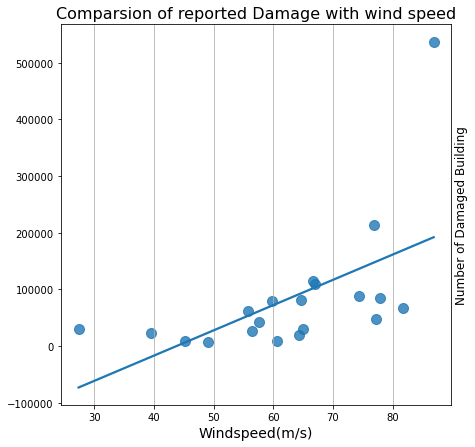

In [20]:
df_impact_hazard['typhoon_name']=df_impact_hazard['typhoon'].apply(lambda x:(x[:-4].upper()+'-'+x[-4:]))
 
df_im_haz=df_impact_hazard[['typhoon_name','rainfall_Total','v_max','Totally']].groupby('typhoon_name').agg(rainfall_Total=('rainfall_Total', max), v_max=('v_max', max), Totally=('Totally', sum)).sort_values(by='Totally',ascending=False).head(n=20)
#display(df_im_haz)

df_im_haz.rename(columns={"rainfall_Total": "Total Rainfall", "v_max": "Maximum Wind", "Totally": "Damaged Buildings"},inplace=True)

import matplotlib.pyplot as plt
import seaborn as sns
# Initialize the figure with a logarithmic x axis
plt.rcParams.update({'font.size': 12})
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="linear", xscale="linear")

sns.regplot (y='Damaged Buildings', x='Maximum Wind', data=df_im_haz,scatter_kws={"s": 100},order=1,ci=0)  
# Plot the orbital period with horizontal boxes
#sns.relplot(y='Damaged Buildings', x='Maximum Wind', data=df_im_haz,palette="vlag")

# Add in points to show each observation
#sns.stripplot(y='Models', x='MAPE', data=df_im_haz,size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
#ax.set(ylabel="")
ax.set_title('Comparsion of reported Damage with wind speed',fontsize=16)
ax.set_xlabel('Windspeed(m/s)',fontsize=14)
ax.set_ylabel('Number of Damaged Building',fontsize=12)
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
#sns.despine(trim=True, left=True)
#f.savefig('algorithms_comparsion_mape.jpg', format='jpg', dpi=600)
ax.yaxis.set_label_position("right")
f.savefig('wind_BUILDINGDAMAGE.jpg', format='jpg', dpi=600)
#fig.savefig('Hazard_damage_comparsion.jpg', format='jpg', dpi=400)

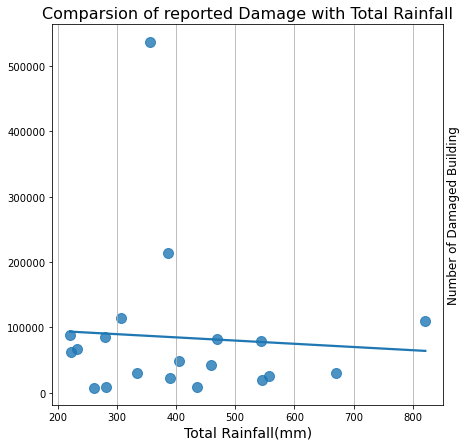

In [21]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="linear", xscale="linear")

sns.regplot (y='Damaged Buildings', x='Total Rainfall', data=df_im_haz,scatter_kws={"s": 100},order=1,ci=0)  
# Plot the orbital period with horizontal boxes
#sns.relplot(y='Damaged Buildings', x='Maximum Wind', data=df_im_haz,palette="vlag")

# Add in points to show each observation
#sns.stripplot(y='Models', x='MAPE', data=df_im_haz,size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
#ax.set(ylabel="")
ax.set_title('Comparsion of reported Damage with Total Rainfall',fontsize=16)
ax.set_xlabel('Total Rainfall(mm)',fontsize=14)
ax.set_ylabel('Number of Damaged Building',fontsize=12)
ax.yaxis.set_label_position("right")
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
#sns.despine(trim=True, left=True)
f.savefig('RAIN_BUILDINGDAMAGE.jpg', format='jpg', dpi=600)


#fig.savefig('Hazard_damage_comparsion.jpg', format='jpg', dpi=400)


### Merge hazard(rainfall and Wind) data with Impac

,rainfall_Total,v_max,Totally
typhoon_name,,,
HAIYAN-2013,356.790000,86.861890,537539.0
DURIAN-2006,386.775000,76.858109,214400.0
RAMMASUN-2014,306.575000,66.632361,114309.0
MELOR-2015,820.863636,67.048448,110036.0
BOPHA-2012,221.366667,74.396642,89090.0
NOCK-TEN-2016,279.742857,77.896034,85233.0
KAMMURI-2019,469.663636,64.637185,81581.0
FENGSHEN-2008,542.900000,59.710869,79169.0
GONI-2020,232.875000,81.744203,67631.0


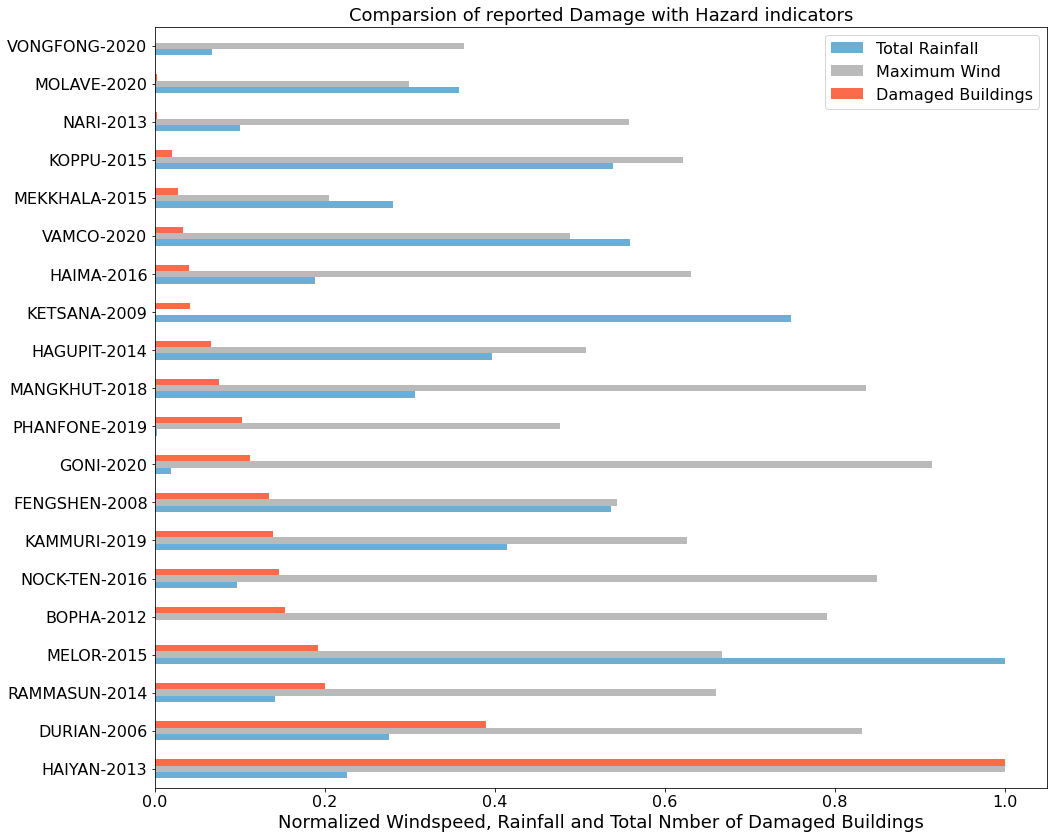

In [23]:
df_impact_hazard['typhoon_name']=df_impact_hazard['typhoon'].apply(lambda x:(x[:-4].upper()+'-'+x[-4:]))
 
df_im_haz=df_impact_hazard[['typhoon_name','rainfall_Total','v_max','Totally']].groupby('typhoon_name').agg(rainfall_Total=('rainfall_Total', max), v_max=('v_max', max), Totally=('Totally', sum)).sort_values(by='Totally',ascending=False).head(n=20)
display(df_im_haz)

def f(s):
    rmalized_df=(s-s.min())/(s.max()-s.min())
    return rmalized_df#s/s.max()

df_im_haz=df_im_haz[['rainfall_Total','v_max','Totally']].apply(f, axis=0)

df_im_haz.rename(columns={"rainfall_Total": "Total Rainfall", "v_max": "Maximum Wind", "Totally": "Damaged Buildings"},inplace=True)
df_im_haz
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(16, 14))

 
df_im_haz.plot(ax=ax,kind='barh',color=['#6baed6','#bababa','#fb6a4a'])

ax.set_title('Comparsion of reported Damage with Hazard indicators',fontsize=18)
ax.set_xlabel('Normalized Windspeed, Rainfall and Total Nmber of Damaged Buildings',fontsize=18)
ax.set_ylabel('',fontsize=14)


fig.savefig('Hazard_damage_comparsion.jpg', format='jpg', dpi=400)

#   

In [27]:
#df_total=pd.merge(df_impact_hazard, df_predisasters,  how='left', left_on=['Mun_Code', 'typhoon'], right_on = ['Mun_Code', 'typhoon'])
df_total=pd.merge(df_impact_hazard, df_predisasters,  how='left', left_on='Mun_Code', right_on = 'Mun_Code')

df_total=df_total[df_total['v_max'].notnull()]
df_total=df_total[df_total['rainfall_max_6h'].notnull()]
 
#df_total=df_total[df_total['dis_track_min']<100]
#display(df_total)



###  Normalize data uisng population size or number of housing uints per manucipality (Calculate percentage per manucipality)

In [28]:

def division(x, y):
    try:
        value =100* (x / y)
        
    except:
        value = np.nan
    
    return 100 if value>100 else value


  

# Setting the new damage threshold

df_total["perc_dmg"] = df_total.apply(lambda x: division(x["Totally"], x["Housing Units"]), axis=1).values



df_total["vulnerable_groups"] = df_total.apply(lambda x: division(x["vulnerable_groups"], x["Total Pop"]), axis=1).values
df_total["pantawid_pamilya_beneficiary"] = df_total.apply(lambda x: division(x["pantawid_total_pop"], x["Total Pop"]), axis=1).values

#display(df_total)

### filter final data frame for only relevant features 

In [29]:
df_total=df_total.filter(['Mun_Code', 'typhoon', 'rainfall_Total', 'rainfall_max_6h',
                 'rainfall_max_24h', 'v_max', 'dis_track_min','landslide_per', 'stormsurge_per',
                 'Bu_p_inSSA','Bu_p_LS', 'Red_per_LSbldg', 'Or_per_LSblg',
                 'Yel_per_LSSAb','RED_per_SSAbldg', 'OR_per_SSAbldg', 
                 'Yellow_per_LSbl', 'mean_slope','mean_elevation_m', 
                 'ruggedness_stdev', 'mean_ruggedness','slope_stdev',
                 'poverty_perc', 'with_coast', 'coast_length','Housing Units', 'Strong Roof/Strong Wall',
                 'Strong Roof/Light Wall', 'Strong Roof/Salvage Wall',
                 'Light Roof/Strong Wall', 'Light Roof/Light Wall',
                 'Light Roof/Salvage Wall', 'Salvaged Roof/Strong Wall',
                 'Salvaged Roof/Light Wall', 'Salvaged Roof/Salvage Wall',
                 'vulnerable_groups', 'pantawid_pamilya_beneficiary','perc_dmg'])


df_total.rename(columns ={"rainfall_Total":"HAZ_rainfall_Total",
                                     'rainfall_max_6h':'HAZ_rainfall_max_6h',
                                     'rainfall_max_24h':'HAZ_rainfall_max_24h',
                                     'v_max':'HAZ_v_max',
                                     'dis_track_min':'HAZ_dis_track_min',
                                     'binary_dmg':'DAM_binary_dmg',
                                     'perc_dmg':'DAM_perc_dmg',
                                    'landslide_per':'GEN_landslide_per',
                                    'stormsurge_per':'GEN_stormsurge_per',
                                    'Bu_p_inSSA':'GEN_Bu_p_inSSA',
                                    'Bu_p_LS':'GEN_Bu_p_LS',
                                     'Red_per_LSbldg':'GEN_Red_per_LSbldg',
                                    'Or_per_LSblg':'GEN_Or_per_LSblg',
                                     'Yel_per_LSSAb':'GEN_Yel_per_LSSAb',
                                    'RED_per_SSAbldg':'GEN_RED_per_SSAbldg',
                                     'OR_per_SSAbldg':'GEN_OR_per_SSAbldg',
                                    'Yellow_per_LSbl':'GEN_Yellow_per_LSbl',
                                     'mean_slope':'TOP_mean_slope',
                                    'mean_elevation_m':'TOP_mean_elevation_m',
                                     'ruggedness_stdev':'TOP_ruggedness_stdev',
                                    'mean_ruggedness':'TOP_mean_ruggedness',
                                     'slope_stdev':'TOP_slope_stdev',
                                     'poverty_perc':'VUL_poverty_perc',
                                    'with_coast':'GEN_with_coast',
                                     'coast_length':'GEN_coast_length',
                                     'Housing Units':'VUL_Housing_Units',
                                    'Strong Roof/Strong Wall':"VUL_StrongRoof_StrongWall",
                                    'Strong Roof/Light Wall':'VUL_StrongRoof_LightWall',
                                    'Strong Roof/Salvage Wall':'VUL_StrongRoof_SalvageWall',
                                    'Light Roof/Strong Wall':'VUL_LightRoof_StrongWall',
                                    'Light Roof/Light Wall':'VUL_LightRoof_LightWall',
                                    'Light Roof/Salvage Wall':'VUL_LightRoof_SalvageWall',
                                    'Salvaged Roof/Strong Wall':'VUL_SalvagedRoof_StrongWall',
                                    'Salvaged Roof/Light Wall':'VUL_SalvagedRoof_LightWall',
                                    'Salvaged Roof/Salvage Wall':'VUL_SalvagedRoof_SalvageWall',
                                    'vulnerable_groups':'VUL_vulnerable_groups',
                                    'pantawid_pamilya_beneficiary':'VUL_pantawid_pamilya_beneficiary'},inplace=True)




In [30]:
selected_columns=['Mun_Code', 'typhoon', 'HAZ_rainfall_Total', 'HAZ_rainfall_max_6h',
'HAZ_rainfall_max_24h','HAZ_v_max', 'HAZ_dis_track_min','GEN_landslide_per', 'GEN_stormsurge_per',
'GEN_Bu_p_inSSA','GEN_Bu_p_LS', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg','GEN_Yel_per_LSSAb',
'GEN_RED_per_SSAbldg', 'GEN_OR_per_SSAbldg','GEN_Yellow_per_LSbl', 'TOP_mean_slope', 'TOP_mean_elevation_m',
'TOP_ruggedness_stdev', 'TOP_mean_ruggedness', 'TOP_slope_stdev','VUL_poverty_perc', 'GEN_with_coast',
'GEN_coast_length','VUL_Housing_Units', 'VUL_StrongRoof_StrongWall','VUL_StrongRoof_LightWall',
'VUL_StrongRoof_SalvageWall','VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall','VUL_LightRoof_SalvageWall',
'VUL_SalvagedRoof_StrongWall','VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall','VUL_vulnerable_groups',
'VUL_pantawid_pamilya_beneficiary','DAM_perc_dmg']



df_total = df_total.filter(selected_columns)
display(df_total)   

,Mun_Code,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
40,PH175101000,durian2006,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,...,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,57.522520,3.632568
41,PH175101000,durian2006,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,...,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,57.522520,3.632568
42,PH175101000,durian2006,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,...,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,57.522520,3.632568
43,PH175101000,durian2006,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,...,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,57.522520,3.632568
44,PH175101000,durian2006,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,...,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,57.522520,3.632568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648235,PH052011000,noul2015,47.062500,3.289583,1.731771,15.018557,177.362033,1.05,10.84,10.80,...,0.247359,3.035165,14.032625,0.260730,0.020056,0.113652,0.086910,1.129667,25.856076,NaN
2648236,PH052011000,noul2015,47.062500,3.289583,1.731771,15.018557,177.362033,1.05,10.84,10.80,...,0.247359,3.035165,14.032625,0.260730,0.020056,0.113652,0.086910,1.129667,25.856076,NaN
2648237,PH052011000,noul2015,47.062500,3.289583,1.731771,15.018557,177.362033,1.05,10.84,10.80,...,0.247359,3.035165,14.032625,0.260730,0.020056,0.113652,0.086910,1.129667,25.856076,NaN
2648238,PH052011000,noul2015,47.062500,3.289583,1.731771,15.018557,177.362033,1.05,10.84,10.80,...,0.247359,3.035165,14.032625,0.260730,0.020056,0.113652,0.086910,1.129667,25.856076,NaN


### save final dataframe for model input

In [31]:
#df_predisasters.to_csv("data/model_input/df_predisasters.csv", index=False)
path=os.path.join(wor_dir, "Training-data-new/new data Folder/df_predisasters.csv")
df_predisasters.to_csv(path, index=False)


In [32]:
df_new=pd.DataFrame()
#display(df_new)
display(len(pantawid_pamilya_beneficiary))

df_new=pantawid_pamilya_beneficiary.head(10)
display(df_new)




1640

,Mun_Code,Total # of Active HHs,pantawid_total_pop
0,PH133902000,101,540
1,PH133908000,201,895
2,PH133909000,252,1303
3,PH133910000,989,5810
4,PH133911000,1038,5859
5,PH133912000,916,5916
6,PH133913000,4028,21853
7,PH133903000,430,2362
8,PH133906000,4031,22685
9,PH133907000,198,1125
